![Julia EO 2023 Banner](figures/JuliaEO_banner.png "Julia EO 2023 Banner")


In this hands-on workshop, we will introduce the [SARprocessing.jl](https://github.com/AIRCentre/SARProcessing.jl) package and see how it can be used to work with Sentinel-1 SAR images. The Package is very much so a work in progress so collaborators are welcomed!


This hand-on is somewhat an extention of the [Introduction of SAR, presented at JuliaEO 2023](www.link_to_pres.com). However, we assume no privious knowlegde of SAR data in this notebook.


## Table Of Contents
-  [Include and Introduce SARProcessing.jl](#Include) 
-  [Load and show Image](#show_image)
-  Speckle Reduction
-  Object Detection in SAR images
-  Interferometry

Below we see an example of a Sentinel-1 SAR image acquired near Japan


![GRD Image](figures/s1a-iw-grd-vv-20220713t210909-20220713t210935-044087-054337-001.png "GRD image s1a-iw-grd-vv-20220713t210909-20220713t210935-044087-054337-001")



* Higher intensity in the left side of  the image.

* High and low intensity patterns in the ocean.

* Land has higher intensity than ocean

* High intensity peaks mid ocean




![GRD Image](figures/japan_zoom.png "GRD image s1a-iw-grd-vv-20220713t210909-20220713t210935-044087-054337-001")

* Relativly high and low patched on the water, with some regions looking somewhat homogeneous.
* Lake has low reflectivity
* Moutain structure

**Question**: Is the SAR looking to the right or to the left?



Generally, SAR images are large and we are therefore using smaller subsets for this workshop. Full images can be downloaded from, e.g., https://search.asf.alaska.edu/#/

# [SARprocessing.jl](https://github.com/AIRCentre/SARProcessing.jl)

 <a class="anchor" id="Include"></a>

* Load both  [Single-Look-Complex](https://sentinels.copernicus.eu/web/sentinel/technical-guides/sentinel-1-sar/products-algorithms/level-1-algorithms/single-look-complex) (SLC) and [Ground-Range-Detected](https://sentinels.copernicus.eu/web/sentinel/technical-guides/sentinel-1-sar/products-algorithms/level-1-algorithms/ground-range-detected) (GRD)
 Images  

Two of the big differences between SLC and GRD images are that SLC are complex values with a phase and GRD are not. In 4_insar.ipynb, we will use the phase content of the images. Futhermore, GRD are **multi-looked**, meaning the resoluiton is poorer.

For SLC images, it is important to work in the radar coordinate system. For GRD, not as much.

* Currently only Sentinel-1 is supperted. However, in the future we expect to add more.

* Objective is to add most SAR specific operations. 









![GRD Image](figures/SARprocessing.png "GRD image s1a-iw-grd-vv-20220713t210909-20220713t210935-044087-054337-001")


Firstly, loading the packages

In [59]:
#using Pkg
#Pkg.add(url = "https://github.com/AIRCentre/SARProcessing.jl");
using SARProcessing; 
using Plots;

# Load and Show image
 <a class="anchor" id="show_image"></a>

.tiff images can be loaded using the load_tiff function in the SARProcessing module. 

In [60]:
#test images for the folder
slcSubsetPath = "../test/testData/s1a-iw3-slc-vv_subset_hight9800_10400_width11000_11000.tiff"; 
slc_image = SARProcessing.load_tiff(slcSubsetPath);
grd_image_hom = SARProcessing.load_tiff("../juliaEO2023/data/grd_image_hom.tiff"); # a small subset of a homegenous area in GRD
slc_image[1:4,1:4:end] 

4×351 Matrix{ComplexF64}:
 -27.0-5.0im    -6.0+2.0im    -9.0+2.0im   …   83.0-49.0im     6.0-38.0im
 -40.0-25.0im  -34.0-81.0im  -48.0+29.0im     -91.0-72.0im   -90.0-57.0im
 -29.0+76.0im  -86.0+44.0im   41.0+86.0im      20.0+126.0im  -94.0+102.0im
   0.0+5.0im    16.0+52.0im    8.0-24.0im      23.0-28.0im   131.0+87.0im

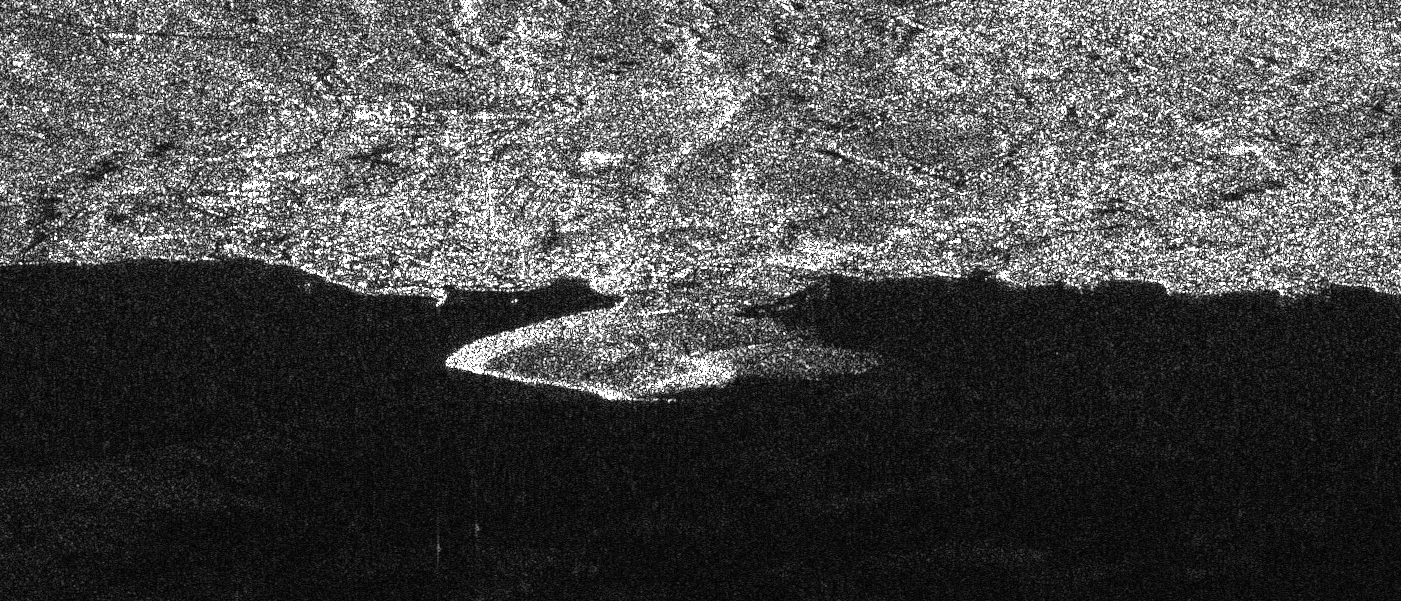

In [61]:
slc_image = abs.(slc_image);
SARProcessing.sar2gray(slc_image, p_quantile = 0.95)

We see:

* point scatters on the ocean
* somewhat homogoneous sea state
* high intensity in the city



The SLC image above is showing Angra do Heroísmo on the Azores. Note that east west is mirrored in the sentinel image

![CFAR windows](figures/where_azores.png "azores region")



The statistics of SAR images are quite important.
- Intensity images are Exponentially distributed
- Multi-looked iamges are gamma distributed.


Generally, the Intensity images are prefered due to a higher S/N ratio compared to amplitude images and nice statistics. 


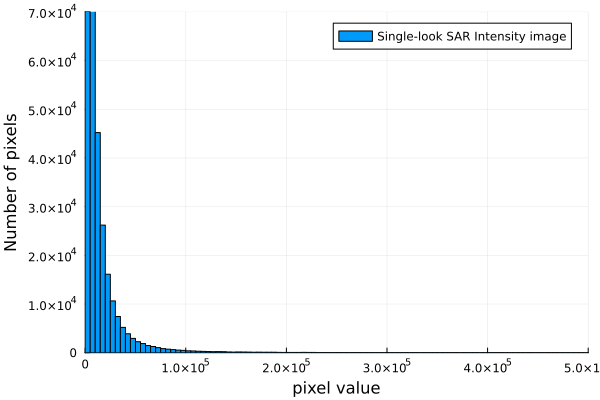

In [65]:
h = histogram(vcat(slc_image.^2...),label="Single-look SAR Intensity image")
ylims!((0,70000))
xlims!((0,500000))
xlabel!("pixel value")
ylabel!("Number of pixels")



**Question**: Is the amplitude image exponentially distributed?

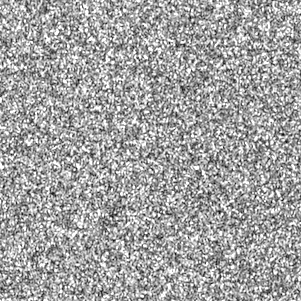

In [66]:
SARProcessing.sar2gray(grd_image_hom, p_quantile = 0.95)

* Relativly high and low patched on the water, with some regions looking somewhat homogeneous.
* Lake has low reflectivity
* Moutain structure

**Question**: Is the SAR looking to the right or to the left?

-----------

Looking at a small multi-looked area

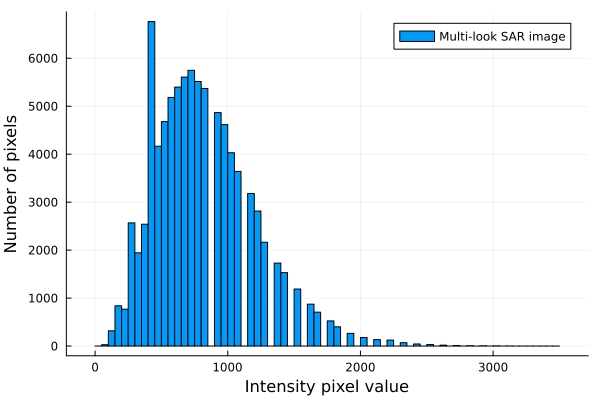

In [67]:
h = histogram(vcat(grd_image_hom.^2...),label="Multi-look SAR image",bins=90)
xlabel!("Intensity pixel value")
ylabel!("Number of pixels")



The intensity of a multi-looked image is gamma distributed